# **Animal Competition (40%)**
For the non-competition mode, we will use the Animal (https://cloudstor.aarnet.edu.au/plus/s/cZYtNAeVhWD6uBX) dataset. This dataset contains images of 151 different animals. 

The dataset contains a total of 6270 images corresponding to the name of animal types.

All images are RGB images of 224 pixels wide by 224 pixels high in .jpg format. The images are separated in 151 folders according to their respective class.

The task is to categorize each animal into one of 151 categories. 

We provide a baseline by the following steps:


*   Loding and Analysing the dataset using torchvision.
*   Defining a simple convolutional neural network. 
*   How to use existing loss function for the model learning. 
*   Train the network on the training data. 
*   Test the trained network on the testing data. 

The following trick/tweak(s) could be considered:
-------
1. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out. 
2. Use of a new loss function.
3. Data augmentation
4. Architectural Changes: Batch Normalization, Residual layers, Attention Block, and other varients.
5. Others

Your code should be modified from the provided baseline. A pdf report is required to explain the tricks you employed, and the imporvements they achieved.
Marking Rules:
-------
We will mark the resykts based on the final test accuracy on testing images and your report.

Final mark = acc_mark + efficiency mark + report mark + bonus mark
###Acc_mark 15:



|Accuracy|Mark|
|---|---|
| >98%|          15|
|>92%|         11|
|>88%  |        7|
|>75%  |      3|
|>55%  |      1|
|Not implemented| 0|

###Efficiency mark 5:

Efficiency is evaluated by the computational costs (flops: https://en.wikipedia.org/wiki/FLOPS). Please report the computational costs for your final model and attach the code/process about how you calculate it.

|Efficiency|Mark|
|---|---|
|<0.69G|          5|
|<1 G|         4|
|<5 G  |        3|
|<10 G |      2|
|<20 G  |      1|
|Not implemented| 0|

###Report mark 20:
1. Introduction and your understanding to the baseline model: 2 points

2. Employed more than three tricks with ablation studies to improve the accuracy: 6 points

Clearly explain the reference, motivation and design choice for each trick/tweak(s). Providing the experimental results in tables.
Example table:

|Trick1|Trick2|Trick3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

Observation and discussion based on the experiment results.

3. Expaination of the methods on reducing the computational cost and/or improve the trade-off between accuracy and efficiency: 4 points

4. Explaination of the code implementation：3 points

5. Visulization results: e.g. training and testing accuracy/loss for each model, case studies: 3 points

6. Open ended:  Limitations, conclusions, failure cases analysis...: 2 points

###Bouns mark:
1. Top three results: 2 points
2. Fancy designs: 2 points



In [ ]:
##################################################################################################################################
### Subject: Computer Vision 
### Year: 2022
### Student Name:Haochen Liu
### Student ID: a1802218
### Comptetion Name: Animal Classification Competition
### Final Results:
### ACC: 94.85%      FLOPs: 2.14 G
##################################################################################################################################

In [1]:
# Importing libraries. 

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Mounting G-Drive to get your dataset. 
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU. 
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971 
from google.colab import drive
drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/drive/MyDrive/AR_0515_a2a3/dataset/dataset/'
classes = os.listdir(data_dir)

Mounted at /content/drive


In [9]:
# Performing Image Transformations. 
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])

In [10]:
dataset = ImageFolder(data_dir, transform=train_transform)

In [11]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [12]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [13]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  ailurus-fulgens (5)


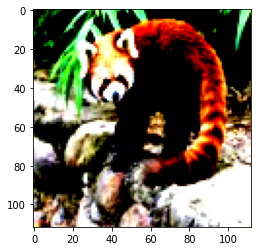

In [14]:
show_image(*dataset[200])

In [10]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [11]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(5330, 313, 627)

In [12]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


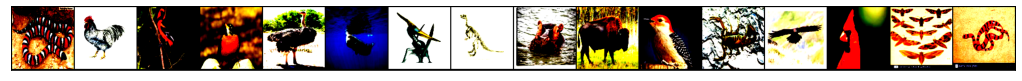

In [13]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [14]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-5 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 5
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_5 = correct[:5].reshape(-1).float().sum(0, keepdim=True)

        return correct_5.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [17]:
input_size = 3*112*112
output_size = 151

In [18]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)
        
        return F.log_softmax(X, dim=1)

In [ ]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes)
model.cuda()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [ ]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 151])
out[0]: tensor([-5.0245, -4.9871, -4.9581, -5.0612, -5.0744, -4.9898, -5.0043, -5.0019,
        -5.0555, -5.0350, -5.0478, -5.0216, -4.9988, -5.0332, -5.0335, -5.0309,
        -5.0483, -5.0100, -5.0473, -5.0797, -5.0219, -5.0230, -5.0225, -4.9722,
        -4.9992, -4.9637, -4.9655, -5.0419, -5.0247, -4.9751, -5.0043, -5.0472,
        -5.0456, -5.0012, -5.0202, -5.0019, -5.0023, -5.0144, -4.9236, -5.0317,
        -5.0439, -5.0580, -5.0196, -5.0626, -4.9763, -5.0545, -4.9995, -5.0725,
        -5.0021, -5.0152, -5.0210, -5.0484, -4.9665, -5.0733, -5.0392, -5.0388,
        -5.0545, -5.0263, -5.0182, -4.9887, -5.0573, -5.0068, -5.0267, -5.0350,
        -5.0364, -4.9913, -5.0364, -5.0269, -5.0361, -5.0370, -5.0671, -5.0113,
        -5.0153, -5.0604, -5.0353, -5.0679, -5.0240, -4.9943, -4.9909, -4.9747,
        -5.1116, -5.0007, -5.0556, -4.9527, -4.9922, -4.9707, -5.0416, -5.0313,
        -5.0161, -5.0350, -5.0561, 

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [ ]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(model, device)

In [ ]:
history=[evaluate(model, val_loader)]
history

[{'val_acc': 0.02812500111758709, 'val_loss': 5.015683174133301}]

In [ ]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

627


In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.7875, val_loss: 4.6269, val_acc: 0.1118


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.2527, val_loss: 4.2240, val_acc: 0.2677


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.7297, val_loss: 3.9939, val_acc: 0.3858


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.2557, val_loss: 3.8536, val_acc: 0.4271


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.7277, val_loss: 3.8708, val_acc: 0.4458


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.2680, val_loss: 4.0858, val_acc: 0.4559


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.8364, val_loss: 4.0468, val_acc: 0.4809


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.4458, val_loss: 4.4823, val_acc: 0.4847


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.1694, val_loss: 5.1983, val_acc: 0.4722


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.9125, val_loss: 5.5012, val_acc: 0.4677


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

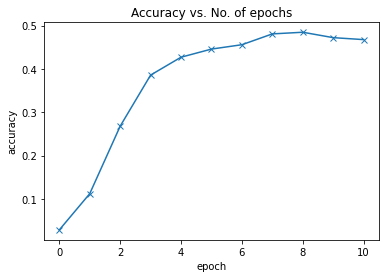

In [ ]:
plot_accuracies(history)

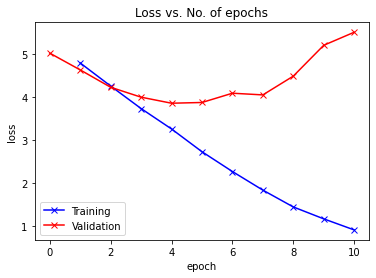

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

{'val_acc': 0.47447919845581055, 'val_loss': 5.294250011444092}

## Modify

### Data Augmentation

In [19]:
# Performing Image Transformations. 
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomCrop(112, padding=16),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(90),
            transforms.ToTensor(),
            transforms.Normalize((0.51209223, 0.5117101, 0.45578277), (0.2869622, 0.27394372, 0.29722568)),
        ])

test_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.ToTensor(),
            transforms.Normalize((0.51209223, 0.5117101, 0.45578277), (0.2869622, 0.27394372, 0.29722568))
        ])
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
val_ds.transform = test_transform
test_ds.transform = test_transform

batch_size = 512
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

Size of training dataset : 6270


In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)
        
        return F.log_softmax(X, dim=1)

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.9324, val_loss: 4.7750, val_acc: 0.0831


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.6645, val_loss: 4.6263, val_acc: 0.1406


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.4913, val_loss: 4.5064, val_acc: 0.1661


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.3805, val_loss: 4.3851, val_acc: 0.1917


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.2526, val_loss: 4.2733, val_acc: 0.2173


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.1275, val_loss: 4.2004, val_acc: 0.2396


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [6], train_loss: 4.0151, val_loss: 4.1009, val_acc: 0.2716


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [7], train_loss: 3.9346, val_loss: 4.0992, val_acc: 0.3035


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [8], train_loss: 3.8426, val_loss: 4.0030, val_acc: 0.3035


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [9], train_loss: 3.7438, val_loss: 4.0524, val_acc: 0.3578


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10], train_loss: 3.6928, val_loss: 3.9381, val_acc: 0.3514


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11], train_loss: 3.6043, val_loss: 3.8167, val_acc: 0.3674


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12], train_loss: 3.5318, val_loss: 3.8489, val_acc: 0.3706


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13], train_loss: 3.4621, val_loss: 3.8227, val_acc: 0.3802


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14], train_loss: 3.3987, val_loss: 3.8033, val_acc: 0.4217


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15], train_loss: 3.3337, val_loss: 3.8159, val_acc: 0.3866


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16], train_loss: 3.2565, val_loss: 3.6990, val_acc: 0.4089


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17], train_loss: 3.1758, val_loss: 3.7442, val_acc: 0.3866


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18], train_loss: 3.1196, val_loss: 3.7139, val_acc: 0.4121


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19], train_loss: 3.0929, val_loss: 3.7223, val_acc: 0.3994


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20], train_loss: 3.0391, val_loss: 3.6957, val_acc: 0.4089


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21], train_loss: 2.9544, val_loss: 3.7417, val_acc: 0.4313


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22], train_loss: 2.9274, val_loss: 3.6008, val_acc: 0.4377


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23], train_loss: 2.9095, val_loss: 3.6082, val_acc: 0.4345


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24], train_loss: 2.8318, val_loss: 3.7502, val_acc: 0.4441


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25], train_loss: 2.8277, val_loss: 3.5193, val_acc: 0.4505


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26], train_loss: 2.7493, val_loss: 3.6193, val_acc: 0.4633


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27], train_loss: 2.7043, val_loss: 3.6772, val_acc: 0.4569


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28], train_loss: 2.6859, val_loss: 3.6882, val_acc: 0.4281


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29], train_loss: 2.6654, val_loss: 3.5475, val_acc: 0.4856


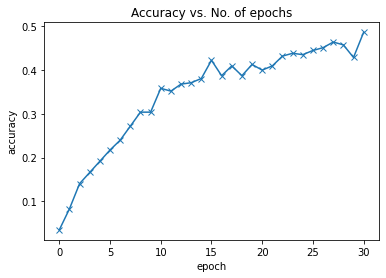

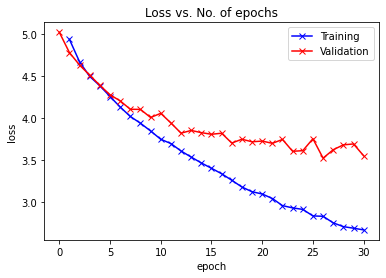

{'val_acc': 0.4680196940898895, 'val_loss': 3.6518092155456543}

In [22]:
model = ConvolutionalNetwork(classes=151)
model = to_device(model, device)
history=[evaluate(model, val_loader)]
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
plot_accuracies(history)
plot_losses(history)
evaluate(model, test_loader)

### Change the strcture of the Network

ResNet18 + Use 224*224 images

In [ ]:
# Performing Image Transformations. 
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.RandomCrop(224, padding=16),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(90),
            transforms.ToTensor(),
            transforms.Normalize((0.51209223, 0.5117101, 0.45578277), (0.2869622, 0.27394372, 0.29722568)),
        ])

test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.51209223, 0.5117101, 0.45578277), (0.2869622, 0.27394372, 0.29722568))
        ])
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
val_ds.transform = test_transform
test_ds.transform = test_transform

batch_size = 512
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

In [23]:
class ResCNN(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        model_res = models.resnet18(pretrained=True)
        self.resnet18_feature_extractor = nn.Sequential(*list(model_res.children())[:-1])
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512,self.num_classes)
        )
    def forward(self,X):
        X = self.resnet18_feature_extractor(X)
        X = self.fc(X)
        return F.log_softmax(X, dim=1)

In [ ]:
model = ResCNN(classes=151)
model = to_device(model, device)
history=[evaluate(model, val_loader)]
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.001
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.7396, val_loss: 3.9386, val_acc: 0.4473


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.9928, val_loss: 2.3044, val_acc: 0.7540


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.2882, val_loss: 2.0598, val_acc: 0.8051


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.9307, val_loss: 1.5499, val_acc: 0.8722


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6710, val_loss: 1.6210, val_acc: 0.8435


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.5256, val_loss: 1.3860, val_acc: 0.8818


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.4066, val_loss: 1.3525, val_acc: 0.8786


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.3183, val_loss: 1.2707, val_acc: 0.9042


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.2400, val_loss: 1.2329, val_acc: 0.9042


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.1975, val_loss: 1.3300, val_acc: 0.8914


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.1810, val_loss: 1.5085, val_acc: 0.8786


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.1538, val_loss: 1.1176, val_acc: 0.9073


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.1329, val_loss: 1.1885, val_acc: 0.9137


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.1078, val_loss: 1.4561, val_acc: 0.8722


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.0941, val_loss: 1.0645, val_acc: 0.9137


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.0801, val_loss: 0.9361, val_acc: 0.9265


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.0731, val_loss: 1.1259, val_acc: 0.9010


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.0604, val_loss: 1.1483, val_acc: 0.9169


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.0633, val_loss: 1.4008, val_acc: 0.8882


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.0578, val_loss: 1.2742, val_acc: 0.8978


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.0568, val_loss: 1.2878, val_acc: 0.8882


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.0552, val_loss: 1.2578, val_acc: 0.9073


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.0511, val_loss: 1.1976, val_acc: 0.9169


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.0492, val_loss: 1.3122, val_acc: 0.8690


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.0638, val_loss: 1.2763, val_acc: 0.9042


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.0615, val_loss: 1.3916, val_acc: 0.8978


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.0701, val_loss: 1.4767, val_acc: 0.8658


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.0795, val_loss: 1.2983, val_acc: 0.9042


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.0785, val_loss: 1.4068, val_acc: 0.8818


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.0868, val_loss: 2.0626, val_acc: 0.8115


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.0949, val_loss: 1.5329, val_acc: 0.8754


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.0856, val_loss: 1.8504, val_acc: 0.8051


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.0828, val_loss: 1.6055, val_acc: 0.8690


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.0826, val_loss: 1.7560, val_acc: 0.8307


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.0727, val_loss: 1.4018, val_acc: 0.8818


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.0618, val_loss: 1.3172, val_acc: 0.9105


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.0488, val_loss: 1.2538, val_acc: 0.9169


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.0439, val_loss: 1.4624, val_acc: 0.9010


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.0376, val_loss: 1.4138, val_acc: 0.8818


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.0377, val_loss: 1.2145, val_acc: 0.8946


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.0385, val_loss: 1.7574, val_acc: 0.8690


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.0300, val_loss: 1.2274, val_acc: 0.9073


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.0264, val_loss: 1.4430, val_acc: 0.8722


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.0248, val_loss: 1.2664, val_acc: 0.9073


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.0213, val_loss: 1.2176, val_acc: 0.9042


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.0221, val_loss: 1.3637, val_acc: 0.9201


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.0289, val_loss: 1.3039, val_acc: 0.8914


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.0283, val_loss: 1.3854, val_acc: 0.8914


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.0320, val_loss: 1.6059, val_acc: 0.8722


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.0359, val_loss: 1.5052, val_acc: 0.8658


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.0400, val_loss: 1.6003, val_acc: 0.8594


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [51], train_loss: 0.0628, val_loss: 1.8721, val_acc: 0.8466


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [52], train_loss: 0.0494, val_loss: 2.2323, val_acc: 0.8211


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [53], train_loss: 0.0530, val_loss: 1.2906, val_acc: 0.9010


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [54], train_loss: 0.0554, val_loss: 1.8541, val_acc: 0.8626


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [55], train_loss: 0.0484, val_loss: 1.7905, val_acc: 0.8147


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [56], train_loss: 0.0479, val_loss: 1.8263, val_acc: 0.8498


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [57], train_loss: 0.0416, val_loss: 1.2809, val_acc: 0.9073


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [58], train_loss: 0.0455, val_loss: 1.4694, val_acc: 0.8786


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [59], train_loss: 0.0496, val_loss: 1.5188, val_acc: 0.8658


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [60], train_loss: 0.0392, val_loss: 1.6813, val_acc: 0.8626


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [61], train_loss: 0.0349, val_loss: 1.4880, val_acc: 0.8850


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [62], train_loss: 0.0381, val_loss: 1.3761, val_acc: 0.9169


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [63], train_loss: 0.0340, val_loss: 1.5466, val_acc: 0.8722


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [64], train_loss: 0.0318, val_loss: 1.4544, val_acc: 0.9010


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [65], train_loss: 0.0337, val_loss: 1.3075, val_acc: 0.8946


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [66], train_loss: 0.0281, val_loss: 1.6186, val_acc: 0.8594


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [67], train_loss: 0.0235, val_loss: 1.4616, val_acc: 0.8722


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [68], train_loss: 0.0268, val_loss: 1.9859, val_acc: 0.8435


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [69], train_loss: 0.0366, val_loss: 1.6636, val_acc: 0.8818


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [70], train_loss: 0.0434, val_loss: 2.0816, val_acc: 0.8339


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [71], train_loss: 0.0458, val_loss: 1.8610, val_acc: 0.8530


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [72], train_loss: 0.0513, val_loss: 1.6371, val_acc: 0.8818


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [73], train_loss: 0.0617, val_loss: 1.9243, val_acc: 0.8435


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [74], train_loss: 0.0703, val_loss: 1.8751, val_acc: 0.8403


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [75], train_loss: 0.0614, val_loss: 1.8557, val_acc: 0.8498


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [76], train_loss: 0.0584, val_loss: 1.5218, val_acc: 0.8850


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [77], train_loss: 0.0553, val_loss: 1.7834, val_acc: 0.8466


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [78], train_loss: 0.0420, val_loss: 1.5953, val_acc: 0.8690


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [79], train_loss: 0.0381, val_loss: 1.5678, val_acc: 0.8946


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [80], train_loss: 0.0307, val_loss: 1.6389, val_acc: 0.8690


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [81], train_loss: 0.0329, val_loss: 1.6462, val_acc: 0.8658


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [82], train_loss: 0.0377, val_loss: 1.4487, val_acc: 0.8786


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [83], train_loss: 0.0390, val_loss: 1.6434, val_acc: 0.8690


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [84], train_loss: 0.0397, val_loss: 1.5252, val_acc: 0.8722


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [85], train_loss: 0.0324, val_loss: 1.8137, val_acc: 0.8626


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [86], train_loss: 0.0375, val_loss: 1.8607, val_acc: 0.8435


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [87], train_loss: 0.0383, val_loss: 1.7030, val_acc: 0.8498


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [88], train_loss: 0.0318, val_loss: 1.8754, val_acc: 0.8498


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [89], train_loss: 0.0276, val_loss: 1.3092, val_acc: 0.9042


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [90], train_loss: 0.0325, val_loss: 1.4038, val_acc: 0.8786


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [91], train_loss: 0.0326, val_loss: 1.9078, val_acc: 0.8466


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [92], train_loss: 0.0276, val_loss: 1.4508, val_acc: 0.8754


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [93], train_loss: 0.0334, val_loss: 2.0963, val_acc: 0.8339


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [94], train_loss: 0.0443, val_loss: 1.7953, val_acc: 0.8562


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [95], train_loss: 0.0426, val_loss: 1.9112, val_acc: 0.8307


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [96], train_loss: 0.0400, val_loss: 1.7002, val_acc: 0.8754


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [97], train_loss: 0.0387, val_loss: 1.4364, val_acc: 0.8882


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [98], train_loss: 0.0322, val_loss: 1.7302, val_acc: 0.8562


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [99], train_loss: 0.0374, val_loss: 1.6628, val_acc: 0.8690


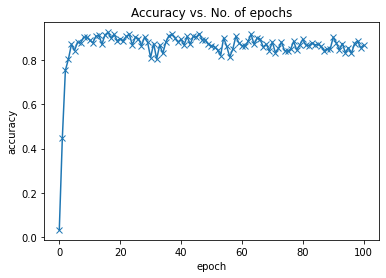

In [ ]:
plot_accuracies(history)

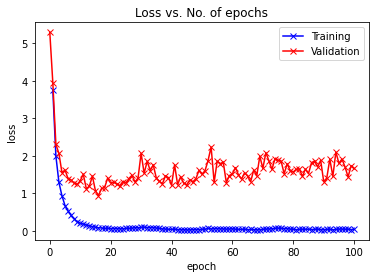

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

{'val_acc': 0.8800016641616821, 'val_loss': 1.7345290184020996}

ResNet18 block 1-2-3 + 112*112 + early stopping

In [39]:
# Performing Image Transformations. 
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomCrop(112, padding=16),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(90),
            transforms.ToTensor(),
            transforms.Normalize((0.51209223, 0.5117101, 0.45578277), (0.2869622, 0.27394372, 0.29722568)),
        ])

test_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.ToTensor(),
            transforms.Normalize((0.51209223, 0.5117101, 0.45578277), (0.2869622, 0.27394372, 0.29722568))
        ])
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
val_ds.transform = test_transform
test_ds.transform = test_transform

batch_size = 512
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

Size of training dataset : 6270


In [40]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    best_val = 0.
    best_con_epoch = 0
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        if best_val < result['val_acc']:
            best_val = result['val_acc']
            best_con_epoch = 0
            torch.save(model.state_dict(), "model_best.pth")
            print(f'Best model update by val acc {best_val}')
        else:
            best_con_epoch += 1
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        if best_con_epoch >= 20:
            break
    return history

In [41]:
class ResCNN(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        model_res = models.resnet18(pretrained=True)
        self.resnet18_feature_extractor = nn.Sequential(*list(model_res.children())[:-2])
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8192,1024),
            nn.Dropout(0.5),
            nn.Linear(1024,self.num_classes)
        )
    def forward(self,X):
        X = self.resnet18_feature_extractor(X)
        X = self.fc(X)
        return F.log_softmax(X, dim=1)

  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.03194887936115265
Epoch [0], train_loss: 10.7201, val_loss: 1982.2676, val_acc: 0.0319


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [1], train_loss: 8.2705, val_loss: 1718.4817, val_acc: 0.0319


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.03833865746855736
Epoch [2], train_loss: 9.4004, val_loss: 53.9152, val_acc: 0.0383


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [3], train_loss: 9.1848, val_loss: 28.0891, val_acc: 0.0383


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [4], train_loss: 10.0195, val_loss: 5.4862, val_acc: 0.0351


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.04792332276701927
Epoch [5], train_loss: 7.3867, val_loss: 5.3341, val_acc: 0.0479


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [6], train_loss: 6.0824, val_loss: 5.2951, val_acc: 0.0479


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.0702875405550003
Epoch [7], train_loss: 5.5301, val_loss: 10.7289, val_acc: 0.0703


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.12140575051307678
Epoch [8], train_loss: 5.2165, val_loss: 6.2434, val_acc: 0.1214


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [9], train_loss: 4.8770, val_loss: 4.7511, val_acc: 0.1086


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.15974441170692444
Epoch [10], train_loss: 4.7167, val_loss: 5.0112, val_acc: 0.1597


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.18210862576961517
Epoch [11], train_loss: 4.5218, val_loss: 4.4567, val_acc: 0.1821


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.23642171919345856
Epoch [12], train_loss: 4.4340, val_loss: 4.4978, val_acc: 0.2364


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.24600638449192047
Epoch [13], train_loss: 4.3247, val_loss: 4.2124, val_acc: 0.2460


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.2555910348892212
Epoch [14], train_loss: 4.2168, val_loss: 4.1498, val_acc: 0.2556


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.29392969608306885
Epoch [15], train_loss: 4.1179, val_loss: 4.1051, val_acc: 0.2939


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.3226836919784546
Epoch [16], train_loss: 4.0095, val_loss: 3.9474, val_acc: 0.3227


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17], train_loss: 3.9304, val_loss: 4.0544, val_acc: 0.3067


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18], train_loss: 3.8997, val_loss: 3.9916, val_acc: 0.3099


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.3482428193092346
Epoch [19], train_loss: 3.7922, val_loss: 3.8909, val_acc: 0.3482


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.36741212010383606
Epoch [20], train_loss: 3.6968, val_loss: 3.8945, val_acc: 0.3674


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21], train_loss: 3.6681, val_loss: 3.8001, val_acc: 0.3514


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22], train_loss: 3.5784, val_loss: 3.7868, val_acc: 0.3578


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.3929712474346161
Epoch [23], train_loss: 3.5255, val_loss: 3.6567, val_acc: 0.3930


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.43130990862846375
Epoch [24], train_loss: 3.4307, val_loss: 3.6112, val_acc: 0.4313


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.4472843408584595
Epoch [25], train_loss: 3.3492, val_loss: 3.5701, val_acc: 0.4473


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.4536741077899933
Epoch [26], train_loss: 3.2873, val_loss: 3.5313, val_acc: 0.4537


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27], train_loss: 3.2071, val_loss: 3.6136, val_acc: 0.4281


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.4600638747215271
Epoch [28], train_loss: 3.1303, val_loss: 3.4463, val_acc: 0.4601


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.5015974640846252
Epoch [29], train_loss: 3.1175, val_loss: 3.4857, val_acc: 0.5016


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [30], train_loss: 3.2268, val_loss: 3.7920, val_acc: 0.4058


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [31], train_loss: 3.1114, val_loss: 3.3582, val_acc: 0.4952


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.5079872012138367
Epoch [32], train_loss: 2.9569, val_loss: 3.4222, val_acc: 0.5080


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.5207667350769043
Epoch [33], train_loss: 2.9052, val_loss: 3.3219, val_acc: 0.5208


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [34], train_loss: 2.8191, val_loss: 3.4040, val_acc: 0.4888


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.5367411971092224
Epoch [35], train_loss: 2.6916, val_loss: 3.1991, val_acc: 0.5367


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.5623003244400024
Epoch [36], train_loss: 2.6637, val_loss: 3.2938, val_acc: 0.5623


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.5718849897384644
Epoch [37], train_loss: 2.5731, val_loss: 3.2140, val_acc: 0.5719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [38], train_loss: 2.5003, val_loss: 3.1618, val_acc: 0.5495


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [39], train_loss: 2.4837, val_loss: 3.1675, val_acc: 0.5655


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.6006389856338501
Epoch [40], train_loss: 2.4102, val_loss: 3.2147, val_acc: 0.6006


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [41], train_loss: 2.3210, val_loss: 3.2964, val_acc: 0.5751


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.6070287227630615
Epoch [42], train_loss: 2.2908, val_loss: 3.0521, val_acc: 0.6070


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.6293929815292358
Epoch [43], train_loss: 2.2383, val_loss: 3.0276, val_acc: 0.6294


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [44], train_loss: 2.2250, val_loss: 3.1067, val_acc: 0.6166


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [45], train_loss: 2.1572, val_loss: 2.9620, val_acc: 0.6230


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [46], train_loss: 2.1356, val_loss: 3.1434, val_acc: 0.5911


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [47], train_loss: 2.0583, val_loss: 3.0811, val_acc: 0.6230


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [48], train_loss: 1.9740, val_loss: 3.1340, val_acc: 0.5847


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.6453673839569092
Epoch [49], train_loss: 1.9951, val_loss: 2.9635, val_acc: 0.6454


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [50], train_loss: 1.9416, val_loss: 3.0821, val_acc: 0.6390


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [51], train_loss: 1.9262, val_loss: 3.1082, val_acc: 0.6166


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [52], train_loss: 1.8434, val_loss: 3.0519, val_acc: 0.6326


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [53], train_loss: 1.8095, val_loss: 3.1241, val_acc: 0.6230


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [54], train_loss: 1.8229, val_loss: 3.1933, val_acc: 0.6198


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [55], train_loss: 1.7209, val_loss: 3.1404, val_acc: 0.6006


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [56], train_loss: 1.6422, val_loss: 3.2157, val_acc: 0.6166


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [57], train_loss: 1.5532, val_loss: 3.2581, val_acc: 0.6326


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.6485623121261597
Epoch [58], train_loss: 1.5397, val_loss: 2.9424, val_acc: 0.6486


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [59], train_loss: 1.5163, val_loss: 3.2410, val_acc: 0.6454


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [60], train_loss: 1.4487, val_loss: 3.2158, val_acc: 0.6294


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [61], train_loss: 1.4043, val_loss: 3.1468, val_acc: 0.6294


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.6613418459892273
Epoch [62], train_loss: 1.4124, val_loss: 3.2971, val_acc: 0.6613


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [63], train_loss: 1.3760, val_loss: 3.4696, val_acc: 0.6390


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [64], train_loss: 1.3926, val_loss: 3.4919, val_acc: 0.6006


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [65], train_loss: 1.3696, val_loss: 3.2046, val_acc: 0.6198


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [66], train_loss: 1.3100, val_loss: 3.2064, val_acc: 0.6326


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [67], train_loss: 1.2544, val_loss: 3.1050, val_acc: 0.6230


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [68], train_loss: 1.1605, val_loss: 3.1833, val_acc: 0.6518


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [69], train_loss: 1.1283, val_loss: 3.2607, val_acc: 0.6326


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [70], train_loss: 1.1246, val_loss: 3.3026, val_acc: 0.6518


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.6709265112876892
Epoch [71], train_loss: 1.0855, val_loss: 3.2059, val_acc: 0.6709


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [72], train_loss: 1.0465, val_loss: 3.3923, val_acc: 0.6550


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [73], train_loss: 1.0343, val_loss: 3.3179, val_acc: 0.6581


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [74], train_loss: 0.9770, val_loss: 3.9251, val_acc: 0.6102


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [75], train_loss: 0.9854, val_loss: 3.8177, val_acc: 0.6454


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [76], train_loss: 0.9363, val_loss: 3.3807, val_acc: 0.6677


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [77], train_loss: 0.9385, val_loss: 3.4282, val_acc: 0.6709


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [78], train_loss: 0.8440, val_loss: 4.0386, val_acc: 0.6198


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [79], train_loss: 0.8590, val_loss: 3.8921, val_acc: 0.6422


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [80], train_loss: 0.8708, val_loss: 3.8491, val_acc: 0.6518


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [81], train_loss: 0.8147, val_loss: 3.7176, val_acc: 0.6326


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [82], train_loss: 0.8066, val_loss: 3.5330, val_acc: 0.6581


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [83], train_loss: 0.7757, val_loss: 3.7661, val_acc: 0.6518


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [84], train_loss: 0.7768, val_loss: 3.8808, val_acc: 0.6262


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [85], train_loss: 0.7845, val_loss: 3.8940, val_acc: 0.6581


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [86], train_loss: 0.7485, val_loss: 3.6948, val_acc: 0.6550


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.6773163080215454
Epoch [87], train_loss: 0.7745, val_loss: 3.5094, val_acc: 0.6773


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [88], train_loss: 0.6906, val_loss: 4.0348, val_acc: 0.6741


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.6932907104492188
Epoch [89], train_loss: 0.6459, val_loss: 3.5450, val_acc: 0.6933


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [90], train_loss: 0.6131, val_loss: 3.6653, val_acc: 0.6741


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [91], train_loss: 0.6081, val_loss: 4.0142, val_acc: 0.6805


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [92], train_loss: 0.5738, val_loss: 4.2884, val_acc: 0.6486


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [93], train_loss: 0.5513, val_loss: 4.1858, val_acc: 0.6486


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [94], train_loss: 0.5845, val_loss: 4.1803, val_acc: 0.6550


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [95], train_loss: 0.5510, val_loss: 4.0577, val_acc: 0.6741


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [96], train_loss: 0.5295, val_loss: 4.0401, val_acc: 0.6581


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [97], train_loss: 0.4808, val_loss: 4.3692, val_acc: 0.6613


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [98], train_loss: 0.5007, val_loss: 4.3893, val_acc: 0.6518


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [99], train_loss: 0.4839, val_loss: 4.5082, val_acc: 0.6677


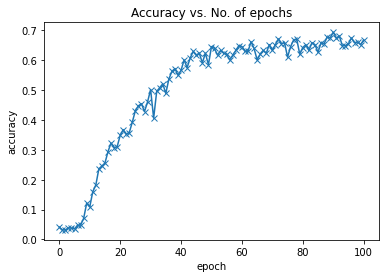

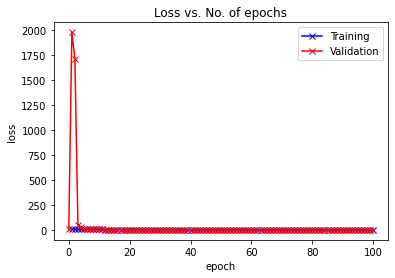

{'val_acc': 0.6600713133811951, 'val_loss': 3.530219316482544}

In [42]:
model = ResCNN(classes=151)
model = to_device(model, device)
history=[evaluate(model, val_loader)]
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.001
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
plot_accuracies(history)
plot_losses(history)
model.load_state_dict(torch.load("model_best.pth"))
evaluate(model, test_loader)

ViT+DeiT

In [44]:
from torchvision import datasets, transforms
# Performing Image Transformations. 
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomApply(transforms=[
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
            ], p=0.2),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.51209223, 0.5117101, 0.45578277), (0.2869622, 0.27394372, 0.29722568)),
        ])

test_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.51209223, 0.5117101, 0.45578277), (0.2869622, 0.27394372, 0.29722568))
        ])
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
val_ds.transform = test_transform
test_ds.transform = test_transform

batch_size = 512
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

Size of training dataset : 6270


In [45]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.model.head.parameters(), lr)
    # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.7)
    best_val = 0.
    best_con_epoch = 0
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        if best_val < result['val_acc']:
            best_val = result['val_acc']
            best_con_epoch = 0
            torch.save(model.state_dict(), "model_best.pth")
            print(f'Best model update by val acc {best_val}')
        else:
            best_con_epoch += 1
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        if best_con_epoch >= 20:
            break
    return history

In [3]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 5.3 MB/s 


In [52]:
class DeiT(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        n_inputs = self.model.head.in_features
        self.model.head = nn.Sequential(
            nn.Linear(n_inputs,512),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(512, self.num_classes)
        )
    def forward(self,X):
        out = self.model(X)
        return out

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.7156549692153931
Epoch [0], train_loss: 4.4624, val_loss: 3.7151, val_acc: 0.7157


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.8402555584907532
Epoch [1], train_loss: 2.9784, val_loss: 2.2879, val_acc: 0.8403


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.9169328808784485
Epoch [2], train_loss: 1.7110, val_loss: 1.4124, val_acc: 0.9169


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.1021, val_loss: 1.1288, val_acc: 0.8946


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.8948, val_loss: 1.0437, val_acc: 0.9105


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.7721, val_loss: 1.0150, val_acc: 0.9137


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.9297124147415161
Epoch [6], train_loss: 0.6824, val_loss: 0.9130, val_acc: 0.9297


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.939297080039978
Epoch [7], train_loss: 0.6054, val_loss: 0.8879, val_acc: 0.9393


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.5833, val_loss: 0.8398, val_acc: 0.9393


  0%|          | 0/11 [00:00<?, ?it/s]

Best model update by val acc 0.9488817453384399
Epoch [9], train_loss: 0.5342, val_loss: 0.8269, val_acc: 0.9489


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.4920, val_loss: 0.8802, val_acc: 0.9201


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.4659, val_loss: 0.8501, val_acc: 0.9329


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.4312, val_loss: 0.8584, val_acc: 0.9425


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.4051, val_loss: 0.8905, val_acc: 0.9265


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.3858, val_loss: 0.8774, val_acc: 0.9297


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.3594, val_loss: 0.7961, val_acc: 0.9329


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.3783, val_loss: 0.8434, val_acc: 0.9361


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.3488, val_loss: 0.8648, val_acc: 0.9265


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.3213, val_loss: 0.7489, val_acc: 0.9457


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.3218, val_loss: 0.8959, val_acc: 0.9265


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.3053, val_loss: 0.8435, val_acc: 0.9265


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.3052, val_loss: 0.9428, val_acc: 0.9233


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.2995, val_loss: 0.8004, val_acc: 0.9393


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.2822, val_loss: 0.8594, val_acc: 0.9361


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.2401, val_loss: 0.7820, val_acc: 0.9393


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.2771, val_loss: 0.8333, val_acc: 0.9361


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.2373, val_loss: 0.8792, val_acc: 0.9361


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.2417, val_loss: 0.8037, val_acc: 0.9393


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.2311, val_loss: 0.9007, val_acc: 0.9233


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.2233, val_loss: 0.7772, val_acc: 0.9361


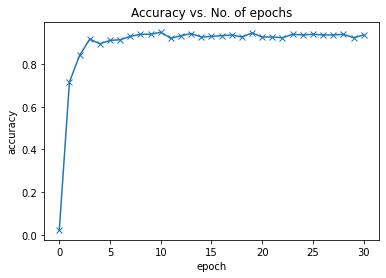

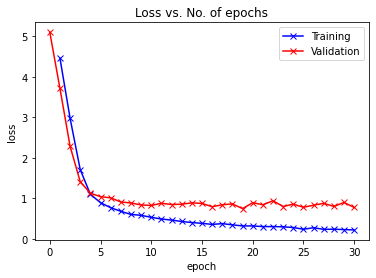

{'val_acc': 0.9485223889350891, 'val_loss': 0.6828449964523315}

In [53]:
model = DeiT(classes=151)
model = to_device(model, device)
history=[evaluate(model, val_loader)]
num_epochs = 100
opt_func = torch.optim.AdamW
lr = 0.001
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
plot_accuracies(history)
plot_losses(history)
model.load_state_dict(torch.load("model_best.pth"))
evaluate(model, test_loader)

##FLOPs

In [54]:
#The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
#Download the code.
!wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
!mv download FLOPs_counter.py
#!rm -rf download

--2022-06-22 23:50:31--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=2qp8i49onpie2shjnt2f9rje9p; path=/plus;; Secure at position 53.
Syntax error in Set-Cookie: oc_sessionPassphrase=i%2FRw5LwT7Wmd%2Bz7IDawTyo%2Bh21sQzdnIAGOajUYSFtUSrDvYxXMUdiKv5SInnizvw5jcyxF3%2Bg8tNo%2BghvfaQT3AAq%2FR4ma8DZ%2FdZvus7WSqK5M6F1D9Jp59%2Bp10sMg4; path=/plus;; Secure at position 178.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2022-06-22 23:50:33 (639 MB/s) - ‘download’ saved [5201/5201]



In [55]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = 151
model = ConvolutionalNetwork(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.69G


In [56]:
num_classes = 151
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model 
model = ResCNN(classes=num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.98G


In [57]:
class ResCNN(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        model_res = models.resnet18(pretrained=True)
        self.resnet18_feature_extractor = nn.Sequential(*list(model_res.children())[:-1])
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512,self.num_classes)
        )
    def forward(self,X):
        X = self.resnet18_feature_extractor(X)
        X = self.fc(X)
        return F.log_softmax(X, dim=1)

In [58]:
num_classes = 151
input = torch.randn(1, 3, 224, 224) # The input size should be the same as the size that you put into your model 
model = ResCNN(classes=num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 3.59G


In [59]:
num_classes = 151
input = torch.randn(1, 3, 224, 224) # The input size should be the same as the size that you put into your model 
model = DeiT(classes=num_classes)
print_model_parm_flops(model, input, detail=False)

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


 + Number of FLOPs: 2.14G
